In [1]:
import os
import sys

import pandas as pd
import seaborn as sns

sys.path.append(os.path.dirname("../src"))

from src.clean_data import get_raw_logs, get_clean_logs

In [2]:
raw_logs = get_raw_logs()

In [3]:
raw_logs.head()

,datetime,user_id,variant,city,event_type,revenue
0,2021-08-01 00:00:39,786179591,B,rome,property_view,NaN
1,2021-08-01 00:02:29,790889727,A,rome,property_view,NaN
2,2021-08-01 00:05:58,471152165,B,london,property_favorite_added,NaN
3,2021-08-01 00:06:27,869904661,B,madrid,property_view,NaN
4,2021-08-01 00:06:29,835833313,B,rome,property_favorite_added,NaN


In [4]:
raw_logs.shape

(16578, 6)

In [5]:
raw_logs["datetime"] = pd.to_datetime(raw_logs["datetime"])
raw_logs["datetime"].min(), raw_logs["datetime"].max()

(Timestamp('2021-08-01 00:00:39'), Timestamp('2021-08-27 23:57:41'))

In [6]:
len(raw_logs["user_id"].unique())

1676

In [7]:
raw_logs["user_id"].value_counts().describe()

count    1676.000000
mean        9.891408
std         6.361274
min         1.000000
25%         5.000000
50%         9.000000
75%        13.000000
max        43.000000
Name: user_id, dtype: float64

In [8]:
raw_logs.drop_duplicates(subset=["user_id"])["variant"].value_counts()

A    839
B    837
Name: variant, dtype: int64

In [9]:
raw_logs.drop_duplicates(subset=["user_id"])["city"].value_counts()

madrid    876
rome      712
london     88
Name: city, dtype: int64

In [10]:
raw_logs["event_type"].value_counts()

property_view              11510
property_favorite_added     4672
booking_request              396
Name: event_type, dtype: int64

In [11]:
raw_logs.loc[~raw_logs["revenue"].isna(), "variant"].value_counts()

A    219
B    161
Name: variant, dtype: int64

In [12]:
raw_logs.dropna(subset=["revenue"]).groupby("variant").agg(
    median_revenue=("revenue", "median")
)


,median_revenue
variant,
A,197.988117
B,350.761653


<AxesSubplot:xlabel='revenue', ylabel='variant'>

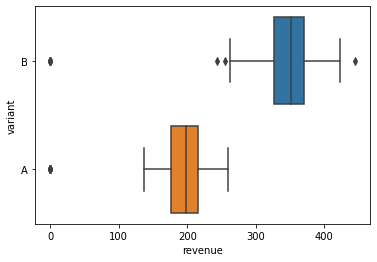

In [13]:
sns.boxplot(data=raw_logs, x="revenue", y="variant")

In [14]:
zero_revenue = raw_logs.loc[
    ((~raw_logs["revenue"].isna()) & (raw_logs["revenue"] < 0.1)), "user_id"
].unique()

In [15]:
len(zero_revenue)

22

In [16]:
several_variants = (
    raw_logs.groupby("user_id")
    .agg(tot_variants=("variant", lambda x: len(set(x))))
    .where(lambda x: x > 1)
    .dropna()
    .index
)

In [17]:
len(several_variants)

38

In [18]:
clean_records = get_clean_logs(raw_logs)

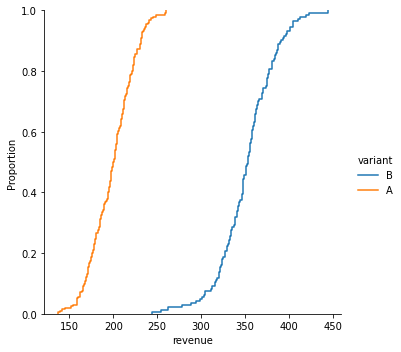

In [19]:
sns.displot(
    data=clean_records,
    x="revenue",
    hue="variant",
    kind="ecdf",
)

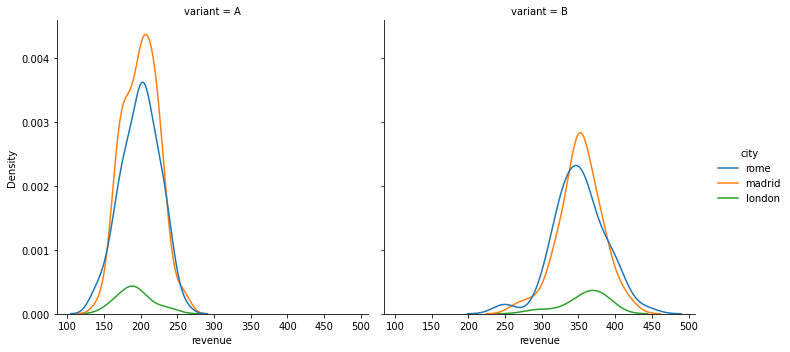

In [21]:
sns.displot(
    data=clean_records,
    x="revenue",
    col="variant",
    kind="kde",
    hue="city",
    col_order=("A", "B")
)

In [23]:
clean_records["day"] = clean_records["datetime"].dt.day

<AxesSubplot:xlabel='datetime'>

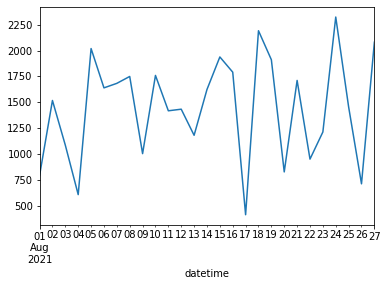

In [26]:
clean_records[clean_records["variant"] == "A"].set_index("datetime")[
    "revenue"
].resample("1D").sum().plot()


<AxesSubplot:xlabel='datetime'>

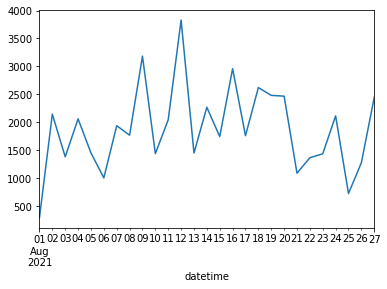

In [28]:
clean_records[clean_records["variant"] == "B"].set_index("datetime")[
    "revenue"
].resample("1D").sum().plot()

<AxesSubplot:xlabel='datetime'>

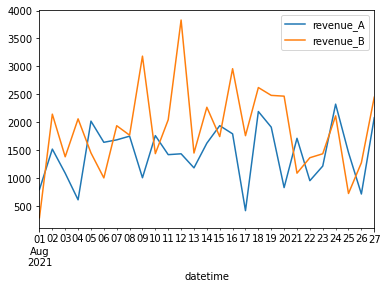

In [29]:
pd.merge(
    clean_records[clean_records["variant"] == "A"].set_index("datetime")[
    "revenue"
].resample("1D").sum().rename("revenue_A"),
    clean_records[clean_records["variant"] == "B"].set_index("datetime")[
    "revenue"
].resample("1D").sum().rename("revenue_B"),
    right_index=True,
    left_index=True
).plot()

In [34]:
clean_records.groupby("user_id").agg(
    min_day=("day", "min"), max_day=("day", "max")
).assign(diff_days=lambda x: x["max_day"] - x["min_day"])["diff_days"].describe(
    percentiles=(0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.75, 0.9, 0.99)
)


count    1618.000000
mean       19.215080
std         6.693906
min         0.000000
10%         9.000000
20%        15.000000
25%        17.000000
30%        18.000000
50%        21.000000
70%        23.000000
75%        24.000000
90%        25.000000
99%        26.000000
max        26.000000
Name: diff_days, dtype: float64